In [102]:
import torch, torchtext
import torch.nn as nn
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from datasets import load_dataset
from numpy.random import default_rng

import random, math, time

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [104]:
# make our work comparable if restarted the kernel
SEED = 1991
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [105]:
# versions
torch.__version__, torchtext.__version__, pd.__version__, np.__version__

('2.3.0', '0.18.0', '2.2.2', '1.24.3')

# ETL: Loading the dataset

For this assignment, the language I chose is Nepali. And the dataset is taken from HuggingFace: https://huggingface.co/datasets/Helsinki-NLP/opus-100/viewer/en-ne

In [106]:
dataset = load_dataset("opus100", "en-ne")

In [107]:
# information about the dataset
dataset

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 406381
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [108]:
# preview
dataset['train'][8]

{'translation': {'en': 'S_ubject:', 'ne': 'विषय:'}}

# EDA - simple investigation

In [109]:
dataset['train']

Dataset({
    features: ['translation'],
    num_rows: 406381
})

In [110]:
# looking at training example
preview = next(iter(dataset['train']))
preview

{'translation': {'en': '_Inv', 'ne': 'Inv'}}

In [111]:
train_size = len(list(iter(dataset['train'])))
train_size

406381

In [112]:
dataset['train'][0]['translation']['en']

'_Inv'

I feel this object has too deeply nested structure. Reducing the dataset size and changing the structure for efficiency and code readability.

In [113]:
# random numnber generator
rand = default_rng(SEED)

# random index from the dataset
# reducing the size of the dataset to 200k
random_index = rand.choice(len(dataset['train']), 200000, replace=False)

dataset['train'] = dataset['train'].filter(lambda data, index: index in random_index, with_indices=True)


In [114]:
# dataset['train'] = dataset['train'].select(random_index)

In [115]:
# Extracts translation col for specific language
# eg: data['translation']['ne']
new_col_gen = lambda data, lang: {lang: data['translation'][lang]}

# New column for Nepali translation
dataset = dataset.map(new_col_gen, fn_kwargs={'lang': "ne"})

# New column for English translation
# Deleting the translation column
dataset = dataset.map(new_col_gen, remove_columns=['translation'], fn_kwargs={'lang': "en"})

In [116]:
# Rechecking the dataset
sample = next(iter(dataset['train']))
sample

{'ne': 'Inv', 'en': '_Inv'}

In [117]:
train_size = len(list(iter(dataset['train'])))
train_size

200000

In [118]:
dataset # easier to work with

DatasetDict({
    test: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['ne', 'en'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
})

# Preprocessing

## Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word.

In [119]:
# Place-holders
token_transform = {}
vocab_transform = {}

SRC_LANG= 'en'
TARG_LANG = 'ne'

In [120]:
from torchtext.data.utils import get_tokenizer
from nepalitokenizers import WordPiece

### Credits:

**Native Language tokenizer:** <br>
Here, I'm using nepalitokenizers which is a pre-trained WordPiece and SentencePiece (Unigram) tokenizers for Nepali language trained using HuggingFace's tokenizers library. Source: https://github.com/basnetsoyuj/nepali-tokenizers

I also used one of spacy's trained pipelines for English `en_core_web_sm`. Spacy is an open-source library of Python that provides advanced capabilities to conduct natural language processing. Details on the pipeline used can be found here: https://spacy.io/models/en

In [121]:
token_transform["en"] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform["ne"] = WordPiece()

In [122]:
print("Sentence: ", dataset['train']['ne'][2])
print("Tokenization: ", token_transform['ne'].encode(dataset['train']['ne'][2]).tokens)

Sentence:  ‡ (# 8225;) डबल ड्यागर
Tokenization:  ['[CLS]', '‡', '(', '###', '82', '##25', ';', '##)', 'डबल', 'ड्य', '##ागर', '[SEP]']


In [123]:
def get_data_token(data, lang):
    '''Tokenize data for a given language'''
    # if lang == 'ne':
    #     return {lang: token_transform[lang].encode(data[lang].lower()).tokens}
    # else:
    #     return {lang: token_transform[lang](data[lang].lower())}
    try:
        # Tokenize the data using the specified language tokenizer
        return {lang: token_transform[lang](data[lang].lower())}
    except:
        # If an exception occurs, use WordPiece tokenizer for Nepali language
        return {lang: token_transform[lang].encode(data[lang].lower()).tokens}

In [124]:
tokenized_dataset = dataset.map(get_data_token, remove_columns=[SRC_LANG], fn_kwargs={'lang': SRC_LANG})

tokenized_dataset = tokenized_dataset.map(get_data_token, remove_columns=[TARG_LANG], fn_kwargs={'lang': TARG_LANG})

Map: 100%|██████████| 2000/2000 [00:00<00:00, 3884.45 examples/s]


In [125]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

## Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [126]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANG, TARG_LANG]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(tokenized_dataset['train'][ln],
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end
# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANG, TARG_LANG]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [127]:
# saveing vocab
torch.save(vocab_transform, 'model/vocab')

In [128]:
#see some example
vocab_transform[SRC_LANG](['here', 'is', 'a', 'unknownword', 'a'])

[237, 20, 11, 0, 11]

In [129]:
#we can reverse it....
mapping = vocab_transform[SRC_LANG].get_itos()

#print 1816, for example
mapping[1891]

'including'

In [130]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [131]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [132]:
#check unique vocabularies
len(mapping)

17074

### Understanding: Preparation of the dataset

So for the preparation of my dataset there were multiple steps. Firstly, I used the Nepali dataset that I found from HuggingFace (which I mentioned in ETL process). It contains English sentences with Nepali translation of it. It also already separated testing, training and validation dataset. 

Moving onto the EDA phase, I changed the object structure to make it more easier to work with while also randomly filtering the training dataset size to 200k. Then I moved on to tokenizing step where I used the previously mentioned `nepalitokenizers`. So, using `get_tokenizer` from torchtext and `WordPiece` from `nepalitokenizers` tokens were created for both English and Nepali respectively. Moving on, we defined special symbols `<unk>`, `<pad>`, `<sos>`, `<eos>` with indexes `0, 1, 2, 3` respectively. Where each symbol has meanings as such:
- `<unk>`: To represent Unknown
- `<pad>`: Padding, used to ensure all sequences are of same length
- `<sos>`: Start of sentence
- `<eos>`: End of sentence

Then, we did Numericalization using `build_vocab_from_iterator` where we turned the tokens into integers. After this, further proccesses are applied.

# Preparing the dataloader

In [133]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# Define a helper function to combine sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        # Iterate over the provided transformations
        for transform in transforms:
            try:
                # Apply the transformation to the text input
                txt_input = transform(txt_input)
            except:
                # If an exception occurs (e.g., if the transform is an encoding operation), catch it
                txt_input = transform.encode(txt_input).tokens
        # Return the transformed text input
        return txt_input
    # Return the function that applies sequential transformations
    return func


# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANG, TARG_LANG]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANG](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TARG_LANG](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [134]:
# Set the batch size for data loaders
batch_size = 64

# Creating DataLoader for the training, validation, test set
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [135]:
for ne, _, en in train_loader:
    break

In [136]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Nepali shape: ", ne.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 5])
Nepali shape:  torch.Size([64, 3])


# Designing the model

## Encoder Layer

In [137]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, atten_type, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, atten_type, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

## Encoder

In [138]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, atten_type, device, max_length = 100):
        super().__init__()
        self.device = device
        self.atten_type = atten_type
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, atten_type,device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src

### Mutli Head Attention Layer

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

In [139]:
class AdditiveAttention(nn.Module):
    def __init__(self, head_dim):
        super(AdditiveAttention, self).__init__()
        
        # Linear layers for additive attention
        self.Wa = nn.Linear(head_dim, head_dim)
        self.Ua = nn.Linear(head_dim, head_dim)
        self.V = nn.Linear(head_dim, 1)

    def forward(self, query, keys):
        # Add singleton dimensions for broadcasting
        query = query.unsqueeze(3)
        keys = keys.unsqueeze(2)

        # Apply additive attention mechanism
        features = torch.tanh(self.Wa(query) + self.Ua(keys))
        
        # Calculate attention scores
        scores = self.V(features).squeeze(-1)
        
        return scores

In [140]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, atten_type, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.atten_type = atten_type
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        self.additive_attention = AdditiveAttention(self.head_dim)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]

        # Calculate attention scores based on the selected attention variant
        if self.atten_type == "multiplicative":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        elif self.atten_type == "general":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2))
        elif self.atten_type == "additive":
            energy = self.additive_attention(Q, K)
        else:
            raise Exception("Incorrect value. Must be either 'multiplicative', 'general', or 'additive'.")
        
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

## Position-wise Feedforward Layer

In [141]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

## Decoder Layer

In [142]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, atten_type, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, atten_type, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, atten_type, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

## Decoder

In [143]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, atten_type, device,max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, atten_type, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [144]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        self.params = {'encoder': encoder, 'decoder': decoder,
                       'src_pad_idx': src_pad_idx, 'trg_pad_idx': trg_pad_idx}
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

# Training

In [145]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [146]:
INPUT_DIM = len(vocab_transform[SRC_LANG])
OUTPUT_DIM = len(vocab_transform[TARG_LANG])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
ATTEN_TYPE = 'additive'

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              ATTEN_TYPE,
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              ATTEN_TYPE,
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [147]:
model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(17074, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (additive_attention): AdditiveAttention(
            (Wa): Linear(in_features=32, out_features=32, bias=True)
            (Ua): Linear(in_features=32, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=True)
          

In [148]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

4370944
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
2572288
 25600
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
1310

In [149]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [150]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [151]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note**: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [152]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [153]:
import gc

In [154]:
input_dim   = len(vocab_transform[SRC_LANG])
output_dim  = len(vocab_transform[TARG_LANG])

# # lower learning rate to increase coplexity
# eg: lr of 0.0001 reached train/val loss: 0 within 2 epochs
lr = 0.0000001 
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

epochs  = 5
clip    = 1

In [155]:
# attention value mappings
atten_map = {'multiplicative': 'Multiplicative Attention', 'general': 'General Attention', 'additive': 'Additive Attention'}

In [156]:
# Attention variants that we defined
for atten_type in ['general', 'multiplicative', 'additive']:

    train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    valid_loader = DataLoader(dataset['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    test_loader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    train_loader_length = len(list(iter(train_loader)))
    val_loader_length   = len(list(iter(valid_loader)))
    test_loader_length  = len(list(iter(test_loader)))

    enc = Encoder(input_dim,
                  HID_DIM,
                  ENC_LAYERS,
                  ENC_HEADS,
                  ENC_PF_DIM,
                  ENC_DROPOUT,
                  atten_type,
                  device)

    dec = Decoder(output_dim,
                  HID_DIM,
                  DEC_LAYERS,
                  DEC_HEADS,
                  DEC_PF_DIM,
                  DEC_DROPOUT,
                  atten_type,
                  device)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    #training hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

    save_path = f'model/{atten_type}_{model.__class__.__name__}.pt'

    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    print(f'\n========= {atten_map[atten_type]} =========')

    for epoch in range(epochs):

        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        #for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)


        if valid_loss <= best_valid_loss:
            best_valid_loss = valid_loss
            torch.save([model.params, model.state_dict()], save_path)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        #lower perplexity is better

    # clearing cache
    del enc
    del dec
    del model
    torch.cuda.empty_cache()
    gc.collect()


========= General Attention =========
Epoch: 01 | Time: 1m 32s
	Train Loss: 8.859 | Train PPL: 7040.503
	 Val. Loss: 8.048 |  Val. PPL: 3126.246
Epoch: 02 | Time: 1m 22s
	Train Loss: 8.161 | Train PPL: 3500.263
	 Val. Loss: 7.563 |  Val. PPL: 1924.765
Epoch: 03 | Time: 1m 21s
	Train Loss: 7.728 | Train PPL: 2271.970
	 Val. Loss: 7.218 |  Val. PPL: 1364.299
Epoch: 04 | Time: 1m 20s
	Train Loss: 7.403 | Train PPL: 1640.472
	 Val. Loss: 6.901 |  Val. PPL: 992.832
Epoch: 05 | Time: 1m 22s
	Train Loss: 7.111 | Train PPL: 1225.625
	 Val. Loss: 6.568 |  Val. PPL: 712.002

========= Multiplicative Attention =========
Epoch: 01 | Time: 1m 27s
	Train Loss: 8.544 | Train PPL: 5133.311
	 Val. Loss: 7.854 |  Val. PPL: 2574.977
Epoch: 02 | Time: 1m 24s
	Train Loss: 7.881 | Train PPL: 2646.598
	 Val. Loss: 7.381 |  Val. PPL: 1605.183
Epoch: 03 | Time: 1m 40s
	Train Loss: 7.499 | Train PPL: 1806.692
	 Val. Loss: 6.996 |  Val. PPL: 1092.033
Epoch: 04 | Time: 2m 14s
	Train Loss: 7.168 | Train PPL: 1297

### Observations:

| Attentions | Training Loss | Traning PPL | Validation Loss | Validation PPL |
|----------|----------|----------|----------|----------|
| General Attention    | 7.111     | 1225.625     | 6.568     | 712.002     |
| Multiplicative Attention    | 6.839     | 933.637     | 6.216     | 500.941     |
| Additive Attention    | 6.860     | 953.436     | 6.254     | 520.322     |

General Attention has the highest Training Loss, Training PPL, Validation Loss and Validation PPL. Multiplicative and Additive Attention has better training loss at `6.839` and `6.860` respectively. 

Multiplicative attention has lowest validation loss `(6.216)` and validation ppl `(500.941)`, while additive came in second with validation loss of `(6.254)` and validation ppl `(520.322)`.

As seen, all 3 attention variations improved their loss and perplexity scores during validation, indicating that they perform well given unseen data.

# Evaluation and Verification

In [157]:
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

valid_loader = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

train_loader_length = len(list(iter(train_loader)))
val_loader_length = len(list(iter(valid_loader)))
test_loader_length = len(list(iter(test_loader)))

In [158]:
input_dim   = len(vocab_transform[SRC_LANG])
output_dim  = len(vocab_transform[TARG_LANG])


batch_size = 32
lr = 0.0000001
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

SRC_PAD_IDX = PAD_IDX

train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))


epochs  = 5
clip    = 1

## General Model

In [159]:
atten_type = "general"
epoch_time_tot = 0

enc = Encoder(input_dim, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, atten_type, device)

dec = Decoder(output_dim, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, atten_type, device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

train_losses = []
valid_losses = []
best_valid_loss = float('inf')


model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_loss_general = []
valid_loss_general = []
print(f'\n========== {atten_map[atten_type]} ==========')


for epoch in range(epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_loss_general.append(train_loss)
    valid_loss_general.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    epoch_time_tot += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Recording every loss for evaluation
final_valid_loss = valid_loss_general[-1]
final_train_loss = train_loss_general[-1]
final_valid_ppl = math.exp(final_valid_loss)
final_train_ppl = math.exp(final_train_loss)

# Calculate time taken for the traning
average_time_per_epoch = epoch_time_tot / epochs
overall_average_time = epoch_time_tot / (epochs * len(train_loader))


print(f"Final Training Loss: {final_train_loss:.3f}")
print(f"Final Validation Loss: {final_valid_loss:.3f}")
print(f"Final Training PPL: {final_train_ppl:.3f}")
print(f"Final Validation PPL: {final_valid_ppl:.3f}")
print(f"Average Time per epoch: {average_time_per_epoch}")
print(f"Overall time taken: {overall_average_time}")


========== General Attention ==========
Epoch: 01 | Time: 2m 41s
	Train Loss: 8.369 | Train PPL: 4309.500
	Val. Loss: 7.478 | Val. PPL: 1768.881
Epoch: 02 | Time: 2m 48s
	Train Loss: 7.474 | Train PPL: 1761.779
	Val. Loss: 6.883 | Val. PPL: 975.716
Epoch: 03 | Time: 3m 26s
	Train Loss: 6.938 | Train PPL: 1030.492
	Val. Loss: 6.297 | Val. PPL: 542.905
Epoch: 04 | Time: 2m 53s
	Train Loss: 6.413 | Train PPL: 609.567
	Val. Loss: 5.704 | Val. PPL: 299.990
Epoch: 05 | Time: 3m 15s
	Train Loss: 5.894 | Train PPL: 362.748
	Val. Loss: 5.215 | Val. PPL: 183.977
Final Training Loss: 5.894
Final Validation Loss: 5.215
Final Training PPL: 362.748
Final Validation PPL: 183.977
Average Time per epoch: 181.1766146659851
Overall time taken: 0.02898825834655762


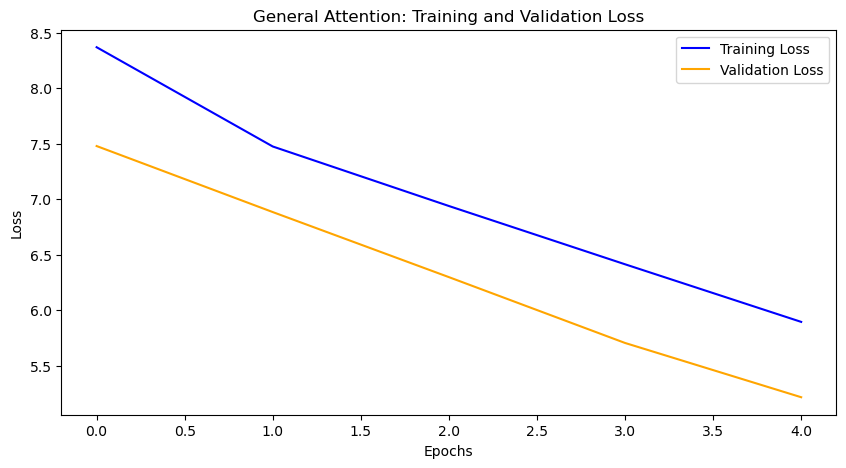

In [160]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(train_loss_general, label='Training Loss', color='blue')
ax.plot(valid_loss_general, label='Validation Loss', color='orange')

plt.title('General Attention: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [161]:
params, state = torch.load('model/general_Seq2SeqTransformer.pt')

model = Seq2SeqTransformer(**params, device=device).to(device)

model.load_state_dict(state)

test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 6.568 | Test PPL: 712.002 |


## Multiplicative Model

In [162]:
atten_type = "multiplicative"
epoch_time_tot = 0

enc = Encoder(input_dim, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, atten_type, device)

dec = Decoder(output_dim, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, atten_type, device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

train_losses = []
valid_losses = []
best_valid_loss = float('inf')

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_loss_multi = []
valid_loss_multi = []
print(f'\n========== {atten_map[atten_type]} ==========')


for epoch in range(epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_loss_multi.append(train_loss)
    valid_loss_multi.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    epoch_time_tot += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses_general
final_train_loss = train_loss_multi[-1]
final_valid_loss = valid_loss_multi[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)


========== Multiplicative Attention ==========
Epoch: 01 | Time: 2m 47s
	Train Loss: 8.354 | Train PPL: 4248.944
	Val. Loss: 7.436 | Val. PPL: 1695.883
Epoch: 02 | Time: 3m 14s
	Train Loss: 7.389 | Train PPL: 1618.441
	Val. Loss: 6.659 | Val. PPL: 779.722
Epoch: 03 | Time: 2m 45s
	Train Loss: 6.748 | Train PPL: 852.196
	Val. Loss: 5.973 | Val. PPL: 392.655
Epoch: 04 | Time: 2m 35s
	Train Loss: 6.176 | Train PPL: 481.190
	Val. Loss: 5.452 | Val. PPL: 233.126
Epoch: 05 | Time: 4m 4s
	Train Loss: 5.690 | Train PPL: 295.752
	Val. Loss: 5.029 | Val. PPL: 152.710


In [163]:
average_time_per_epoch = epoch_time_tot / epochs
overall_average_time = epoch_time_tot / (epochs * len(train_loader))

print(f"Final Training Loss: {final_train_loss:.3f}")
print(f"Final Validation Loss: {final_valid_loss:.3f}")
print(f"Final Training PPL: {final_train_ppl:.3f}")
print(f"Final Validation PPL: {final_valid_ppl:.3f}")
print(f"Average Time per epoch: {average_time_per_epoch}")
print(f"Overall time taken: {overall_average_time}")

Final Training Loss: 5.690
Final Validation Loss: 5.029
Final Training PPL: 295.752
Final Validation PPL: 152.710
Average Time per epoch: 185.5515887260437
Overall time taken: 0.029688254196166993


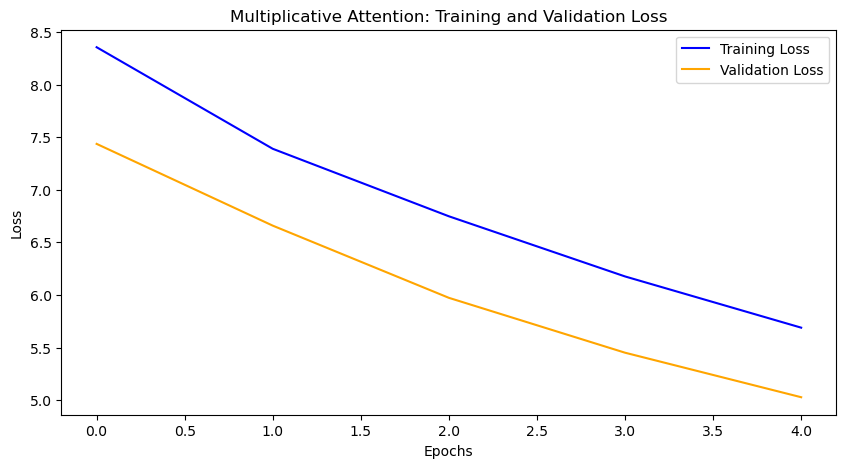

In [164]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(train_loss_multi, label='Training Loss', color='blue')
ax.plot(valid_loss_multi, label='Validation Loss', color='orange')

plt.title('Multiplicative Attention: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [165]:
params, state = torch.load('model/multiplicative_Seq2SeqTransformer.pt')

model = Seq2SeqTransformer(**params, device=device).to(device)

model.load_state_dict(state)

test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 6.216 | Test PPL: 500.941 |


## Additive Model

In [166]:
atten_type = "additive"
epoch_time_tot = 0

enc = Encoder(input_dim, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, atten_type, device)

dec = Decoder(output_dim, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, atten_type, device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

train_losses = []
valid_losses = []
best_valid_loss = float('inf')

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_loss_additive = []
valid_loss_additive = []
print(f'\n========== {atten_map[atten_type]} ==========')


for epoch in range(epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_loss_additive.append(train_loss)
    valid_loss_additive.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    epoch_time_tot += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses_general
final_train_loss = train_loss_additive[-1]
final_valid_loss = valid_loss_additive[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)


========== Additive Attention ==========
Epoch: 01 | Time: 3m 3s
	Train Loss: 8.202 | Train PPL: 3647.405
	Val. Loss: 7.321 | Val. PPL: 1511.581
Epoch: 02 | Time: 3m 3s
	Train Loss: 7.291 | Train PPL: 1466.736
	Val. Loss: 6.582 | Val. PPL: 721.847
Epoch: 03 | Time: 2m 56s
	Train Loss: 6.664 | Train PPL: 783.926
	Val. Loss: 5.893 | Val. PPL: 362.467
Epoch: 04 | Time: 3m 43s
	Train Loss: 6.099 | Train PPL: 445.566
	Val. Loss: 5.383 | Val. PPL: 217.596
Epoch: 05 | Time: 4m 5s
	Train Loss: 5.618 | Train PPL: 275.290
	Val. Loss: 4.976 | Val. PPL: 144.923


In [167]:
average_time_per_epoch = epoch_time_tot / epochs
overall_average_time = epoch_time_tot / (epochs * len(train_loader))

print(f"Final Training Loss: {final_train_loss:.3f}")
print(f"Final Validation Loss: {final_valid_loss:.3f}")
print(f"Final Training PPL: {final_train_ppl:.3f}")
print(f"Final Validation PPL: {final_valid_ppl:.3f}")
print(f"Average Time per epoch: {average_time_per_epoch}")
print(f"Overall time taken: {overall_average_time}")

Final Training Loss: 5.618
Final Validation Loss: 4.976
Final Training PPL: 275.290
Final Validation PPL: 144.923
Average Time per epoch: 202.3310390472412
Overall time taken: 0.032372966247558595


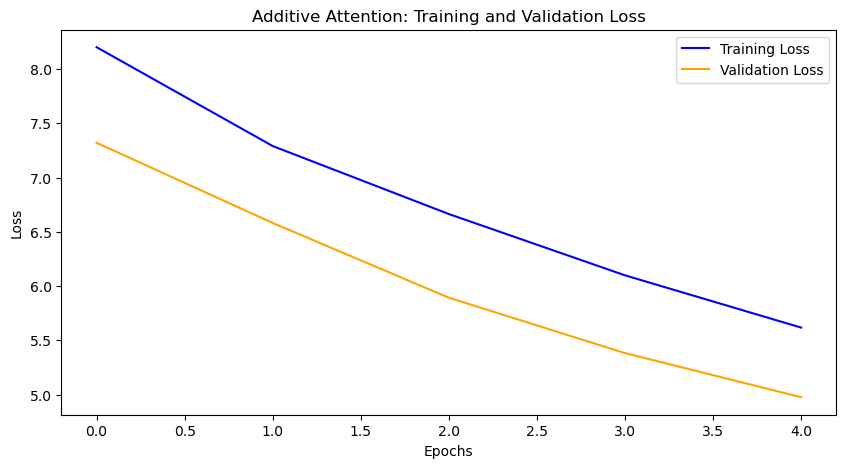

In [168]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(train_loss_additive, label='Training Loss', color='blue')
ax.plot(valid_loss_additive, label='Validation Loss', color='orange')

plt.title('Additive Attention: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
params, state = torch.load('model/additive_Seq2SeqTransformer.pt')

model = Seq2SeqTransformer(**params, device=device).to(device)

model.load_state_dict(state)

test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f"Test Loss: {test_loss:.3f}")
print(f"Test PPL: {math.exp(test_loss):7.3f}")

Test Loss: 0.390
Test PPL:   1.477


# Testing

In [169]:
import os

In [170]:
dataset['test'][14]

{'ne': 'पुन: नामाकरण गर्नुहोस्', 'en': 'Rename'}

In [171]:
src_txt = text_transform[SRC_LANG](dataset['test'][14]['en']).to(device)

print(src_txt)

tensor([2, 0, 3], device='cuda:0')


In [172]:
targ_txt = text_transform[TARG_LANG](dataset['test'][14]['ne']).to(device)
targ_txt

tensor([   2,    4,  165,    8, 1335,    7,    5,    3], device='cuda:0')

In [173]:
src_txt = src_txt.reshape(1, -1)  #because batch_size is 1
targ_txt = targ_txt.reshape(1, -1)

src_txt.shape, targ_txt.shape

(torch.Size([1, 3]), torch.Size([1, 8]))

In [174]:
text_length = torch.tensor([src_txt.size(0)]).to(dtype=torch.int64)
text_length

tensor([1])

## Testing General model

In [175]:
load_path = 'model/general_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

model.eval()

start_time = time.time()
with torch.no_grad():
    output, attentions_general = model(src_txt, targ_txt) #turn off teacher forcing

end_time = time.time()


elapsed_time = end_time - start_time

print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size (MB)

print(f"Model size: {model_size:.2f} MB")

Time taken for inference: 0.03021240234375 seconds
Model size: 52.69 MB


Since batch size is 1, we just take off that dimension

In [176]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 8, 10048])

In [177]:
output = output.squeeze(0)
output.shape

torch.Size([8, 10048])

We shall remove the first token since it's zeroes anyway

In [178]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([7, 10048])

Then we just take the top token with highest probabilities

In [179]:
output

tensor([[-0.1313,  0.1178, -0.2182,  ...,  0.1597,  0.0201, -0.5830],
        [-0.1686,  0.1050, -0.2980,  ...,  0.1893,  0.0384, -0.5439],
        [-0.2685,  0.0812, -0.2805,  ...,  0.1755,  0.0734, -0.5033],
        ...,
        [-0.1480,  0.1104, -0.1755,  ...,  0.0960,  0.0885, -0.5215],
        [-0.1280,  0.0921, -0.2544,  ...,  0.1594,  0.1591, -0.5549],
        [-0.0832,  0.2360, -0.2502,  ...,  0.1271,  0.1282, -0.5702]],
       device='cuda:0')

In [180]:
output_max = output.argmax(1) #returns max indices

In [181]:
output_max

tensor([7509, 7509,    3, 7509, 7089, 6678, 9180], device='cuda:0')

Get the mapping of the target language

In [182]:
mapping = vocab_transform[TARG_LANG].get_itos()

output_general = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_general.append(token_str)

##सक्यो
##सक्यो
<eos>
##सक्यो
##ket
छर
सिक्दै


In [183]:
mapping[:10]

['<unk>',
 '<pad>',
 '<sos>',
 '<eos>',
 '[CLS]',
 '[SEP]',
 '।',
 'गर्नुहोस्',
 ':',
 '##होस्']

In [186]:
print(output_general)

['##सक्यो', '##सक्यो', '##सक्यो', '##ket', 'छर', 'सिक्दै']


## Testing Multiplicative model

In [187]:
load_path = 'model/multiplicative_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

model.eval()

start_time = time.time()
with torch.no_grad():
    output, attentions_multiplicative = model(src_txt, targ_txt) #turn off teacher forcing

end_time = time.time()

elapsed_time = end_time - start_time

print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size (MB)

print(f"Model size: {model_size:.2f} MB")

Time taken for inference: 0.01608419418334961 seconds
Model size: 52.69 MB


In [188]:
output.shape #batch_size, trg_len, trg_output_dim
output = output.squeeze(0)
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([7, 10048])

In [189]:
output_max = output.argmax(1) #returns max indices

In [190]:
mapping = vocab_transform[TARG_LANG].get_itos()

In [191]:
output_multi = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_multi.append(token_str)

[CLS]
सदस्यता
[CLS]
लिन्छ
रातो
सदस्यता
रातो


In [192]:
print(output_multi)

['सदस्यता', 'लिन्छ', 'रातो', 'सदस्यता', 'रातो']


## Testing Additive model

In [193]:
load_path = 'model/additive_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

model.eval()

start_time = time.time()
with torch.no_grad():
    output, attentions_additive = model(src_txt, targ_txt) #turn off teacher forcing

end_time = time.time()

elapsed_time = end_time - start_time

print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size (MB)

print(f"Model size: {model_size:.2f} MB")

Time taken for inference: 0.02596592903137207 seconds
Model size: 52.69 MB


In [194]:
output.shape #batch_size, trg_len, trg_output_dim
output = output.squeeze(0)
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([7, 10048])

In [195]:
output_max = output.argmax(1) #returns max indices

In [196]:
mapping = vocab_transform[TARG_LANG].get_itos()

In [197]:
output_addi = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_addi.append(token_str)

##न्दि
##न्दि
##न्दि
##न्दि
सम्बन्ध
सम्बन्ध
##न्दि


In [198]:
print(output_addi)

['##न्दि', '##न्दि', '##न्दि', '##न्दि', 'सम्बन्ध', 'सम्बन्ध', '##न्दि']


## Observation: Performance Analysis

| Attentions | Testing Loss | Testing PPL | Model Size (MB) | Inference Time |Avg. Time per epoch |
|----------|----------|----------|----------|----------|----------|
| General Attention    | 6.568     | 712.002     | 52.69     | 0.030     |181.176     |
| Multiplicative Attention    | 6.216     | 500.941     | 52.69     | 0.016     |185.551    |
| Additive Attention    | 0.390     | 1.477     | 52.69     | 0.025     |202.331     |

All three model has same size of `52.69` MB. In terms of computational efficiency, general attention variation has the lowest average epoch time of `181.176s`, multiplicative coming in second with `185.551s` and finally additive with `202.331s`. 

Similarly, all three variations had low inference time. Among them, Multiplicative attention having the lowest inference time suggests that it can do faster predictions during translation.

# Attention

Let's display the attentions to understand how the source text links with the generated text

In [199]:
attentions_general.shape, attentions_multiplicative.shape, attentions_additive.shape

(torch.Size([1, 8, 8, 3]), torch.Size([1, 8, 8, 3]), torch.Size([1, 8, 8, 3]))

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [200]:
attention_general = attentions_general[0, 0, :, :]
attention_multiplicative = attentions_general[0, 0, :, :]
attention_additive = attentions_additive[0, 0, :, :]

print(attentions_general.shape, attention_multiplicative.shape, attention_additive.shape)

torch.Size([1, 8, 8, 3]) torch.Size([8, 3]) torch.Size([8, 3])


In [201]:
src_tokens = ['<sos>'] + token_transform[SRC_LANG](dataset['test'][1]['en']) + ['<eos>']
src_tokens

['<sos>', 'Treize', '<eos>']

In [202]:
targ_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
targ_tokens

['<sos>',
 '##न्दि',
 '##न्दि',
 '##न्दि',
 '##न्दि',
 'सम्बन्ध',
 'सम्बन्ध',
 '##न्दि']

## Attention Maps

In [203]:
import matplotlib.ticker as ticker

In [220]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(25,15))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

C:\Users\Bidhan\AppData\Local\Temp\ipykernel_10656\3598855863.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Bidhan\AppData\Local\Temp\ipykernel_10656\3598855863.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
c:\Users\Bidhan\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bidhan\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bidhan\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN 

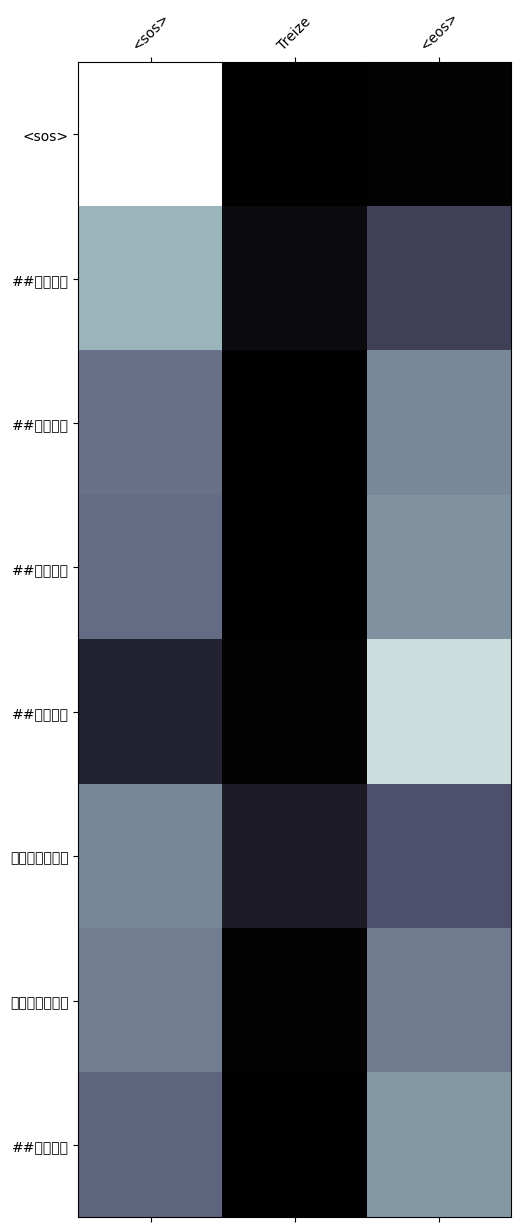

In [221]:
display_attention(src_tokens, targ_tokens, attention_multiplicative)

C:\Users\Bidhan\AppData\Local\Temp\ipykernel_10656\3598855863.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Bidhan\AppData\Local\Temp\ipykernel_10656\3598855863.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
c:\Users\Bidhan\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bidhan\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bidhan\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN 

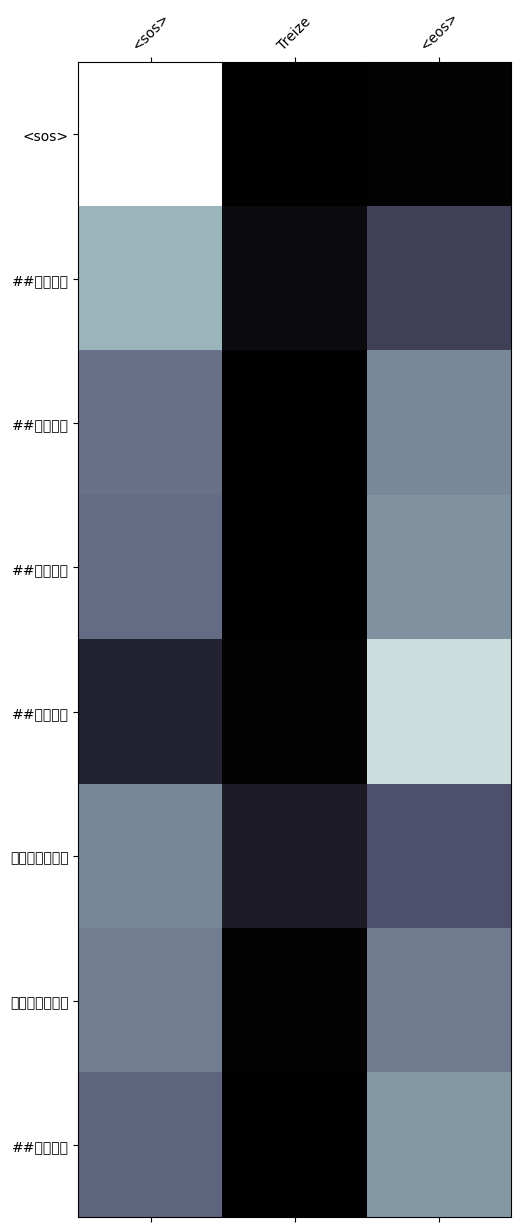

In [222]:
display_attention(src_tokens, targ_tokens, attention_general)

C:\Users\Bidhan\AppData\Local\Temp\ipykernel_10656\3598855863.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Bidhan\AppData\Local\Temp\ipykernel_10656\3598855863.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
c:\Users\Bidhan\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bidhan\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Bidhan\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN 

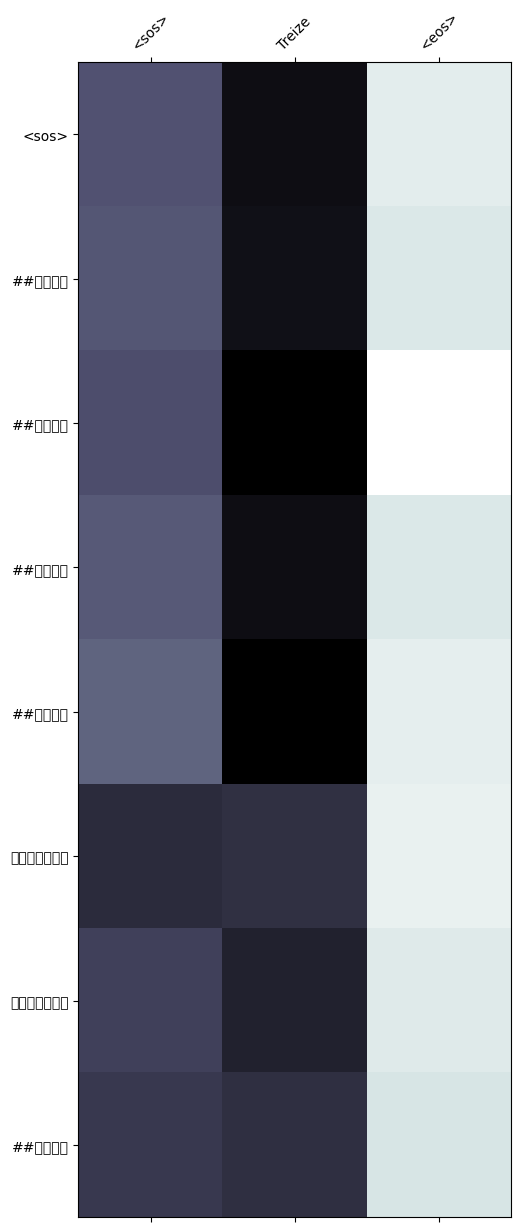

In [223]:
display_attention(src_tokens, targ_tokens, attention_additive)

# Analyzation of Results

Given all the disucussion done in the previous sections. Between all three attention variations additive attention had the lowest perplexity and loss while testing. So, I will be choosing it to implement in the web application.

But all three model had poor translation accuracy which might be due to the low epoch or overfitting.

# Web application interface documentation

For this assignment again, I made the interface using Dash. The entire UI along with necessary model implemenetations are carried out in `app.py` file. It is a simple UI with a query field, tanslate button, some validations and a result section. The demo can be found in the `README.md` file of A3 folder and the actual `demo.gif` file is inside `static` folder. 

The model is integrated with the interface with simple steps. Firstly, the vocab is loaded using `.load` from pytorch and the model is setup by passing its parameters. The model I chose was additive because it performed the best among the 3. Then, Tokenization is carried followed by numericalization and finally tensors are created. So, the overall flow is - prompt is received, processing is done and the token with highest probability is taken and appended to a list. The list is joined to form a sentence and shown to the user.

The user interaction flow is as follows:
- User enters a prompt into the field
- Clicks the translate button
- Translation is shown in the screen